## Imports

In [1]:
%load_ext autoreload
%autoreload 2
import torch
from diffusers import DiffusionPipeline
from diffusers.models.attention_processor import AttnProcessor

/home/pfernand/conda/envs/cmbap-diffusion/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading Pipeline

In [2]:
pipeline = DiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", 
    use_safetensors=True,
)
pipeline.unet.set_attn_processor(AttnProcessor())

Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]


In [ ]:
#pipeline = DiffusionPipeline.from_pretrained(
#    "stabilityai/stable-diffusion-xl-base-1.0", 
#    use_safetensors=True,
#    torch_dtype=torch.float16,
#    variant="fp16"
#)

In [3]:
pipeline.to("cuda")

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.30.0.dev0",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
prompt = "Lisbon during sunset"
outs = pipeline(prompt, return_dict=False, return_cross_attn=True)
image = outs[0][0]
image

In [4]:
from PIL import Image

def latents_to_rgb(latents):
    weights = (
        (60, -60, 25, -70),
        (60,  -5, 15, -50),
        (60,  10, -5, -35)
    )

    weights_tensor = torch.t(torch.tensor(weights, dtype=latents.dtype).to(latents.device))
    biases_tensor = torch.tensor((150, 140, 130), dtype=latents.dtype).to(latents.device)
    rgb_tensor = torch.einsum("...lxy,lr -> ...rxy", latents, weights_tensor) + biases_tensor.unsqueeze(-1).unsqueeze(-1)
    image_array = rgb_tensor.clamp(0, 255)[0].byte().cpu().numpy()
    image_array = image_array.transpose(1, 2, 0)

    return Image.fromarray(image_array)

def pipeline_with_attention(prompt, get_negative_prompt=False, generator=None):
    # callback to extract latent tensors
    decoded_latents = []
    def _decode_tensors(pipe, step, timestep, callback_kwargs):
        latents = callback_kwargs["latents"]
    
        image = latents_to_rgb(latents)
        decoded_latents.append(image)

        return callback_kwargs

    # generate image and get cross-attention
    outs = pipeline(
        prompt, 
        return_dict=False, 
        return_cross_attn=True, 
        generator=generator,     
        callback_on_step_end=_decode_tensors,
        callback_on_step_end_tensor_inputs=["latents"],
    )
    image = outs[0][0]
    cross_attn = outs[2]

    # tokenize prompt to get attention masks
    toks = pipeline.tokenizer(
        prompt,
        padding="max_length",
        max_length=pipeline.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    mask = toks["attention_mask"][0]
    # remove padding from ids and get actual text tokens
    nonpadded_ids = toks["input_ids"][0][mask.bool()]
    tokens = pipeline.tokenizer.convert_ids_to_tokens(nonpadded_ids)

    # apply mask recursively 
    def _apply_mask(attns, mask):
        if isinstance(attns, dict):
            return {k: _apply_mask(v, mask) for k, v in attns.items()}
        elif isinstance(attns, list):
            return [_apply_mask(v, mask) for v in attns]
        elif isinstance(attns, torch.Tensor):
            batch_idx = 0 if get_negative_prompt else 1
            return attns[batch_idx, :, :, mask.bool()]

    cross_attn = _apply_mask(cross_attn, mask)
    return {"image": image, "cross_attn": cross_attn, "tokens": tokens, "latents": decoded_latents}

In [6]:
from IPython.display import display, HTML

def colorize_attention(
            tokens, 
            attention_weights, 
            ignore_special_tokens=True, 
            max_width_shown=1800):
    template = '<span class="barcode"; style="color: black; background-color: rgba(252, 161, 3, {}); display:inline-block;">&nbsp{}&nbsp</span>'
    colored_string = ''
    f = lambda w: w

    if ignore_special_tokens:
        tokens = tokens[1:-1]
        attention_weights = attention_weights[1:-1]
    
    # Normalize attention weights to [0, 1]
    min_weight, max_weight = attention_weights.min(), attention_weights.max()
    normalized_weights = (attention_weights - min_weight) / (max_weight - min_weight)
    
    for token, weight in zip(tokens, normalized_weights):
        colored_string += template.format(weight.item(), f(token))
    
    html_text = f'<div style="width:100%; font-size:14px; font-family: \'CMU serif\';"> {colored_string}</div>'
    return html_text


In [48]:
def average_nested_attention(
    attention_structure, 
    tensor_map=lambda x: x.mean(1).mean(0)
):
    """
    Recursively average a nested attention structure.
    
    :param attention_structure: A nested structure of dictionaries, lists, and tensors
    :return: A single tensor representing the averaged attention weights
    """
    if isinstance(attention_structure, dict):
        # If it's a dictionary, average the results of recursively processing each value
        averaged_values = [average_nested_attention(v, tensor_map) for v in attention_structure.values()]
        return torch.mean(torch.stack(averaged_values), dim=0)
    
    elif isinstance(attention_structure, list):
        # If it's a list, average the results of recursively processing each element
        averaged_values = [average_nested_attention(item, tensor_map) for item in attention_structure]
        return torch.mean(torch.stack(averaged_values), dim=0)
    
    elif isinstance(attention_structure, torch.Tensor):
        # If it's a tensor, we've reached the lowest level. Return the tensor.
        return tensor_map(attention_structure)
    
    else:
        raise ValueError(f"Unexpected type in attention structure: {type(attention_structure)}")

In [64]:
colorize_attention(outs["tokens"],
    average_nested_attention(
        outs["cross_attn"][-1]["up_blocks"]
)
)
import math
sqrt = lambda x: x.sqrt()
outs["cross_attn"][-1]["up_blocks"][2][0][0].shape

16.0


torch.Size([8, 4096, 9])

## Prompt Analysis

In [8]:
prompts = [
    "a red apple on a white table",
    "a futuristic city skyline at sunset",
    "the concept of time",
    "an oil painting of a landscape",
    "a rainy day in Lisbon"
]

In [9]:
prompts_outs = []
seed = 42
for i, prompt in enumerate(prompts):
    generator = torch.Generator(device="cuda").manual_seed(seed+i)
    outs = pipeline_with_attention(prompt, generator=generator)
    prompts_outs.append(outs)
    #display(outs["image"])

100%|██████████| 50/50 [00:06<00:00,  7.86it/s]


### Global Attention

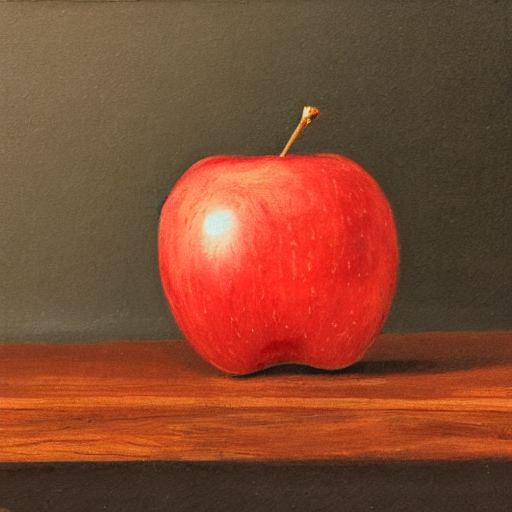

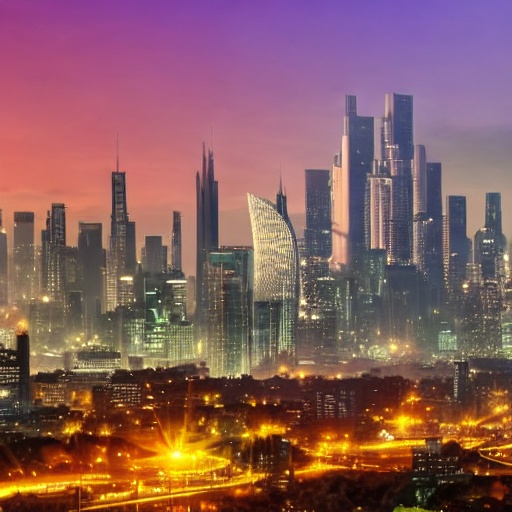

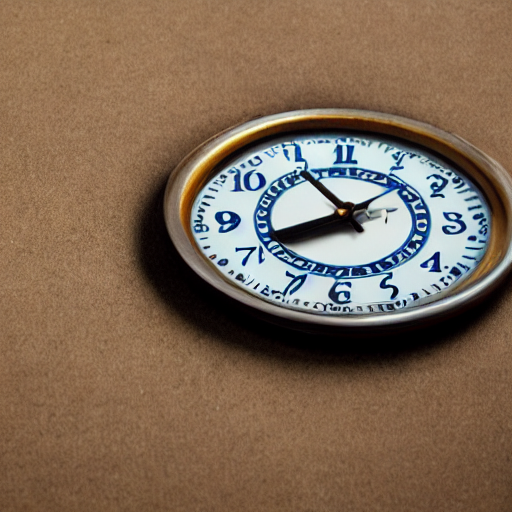

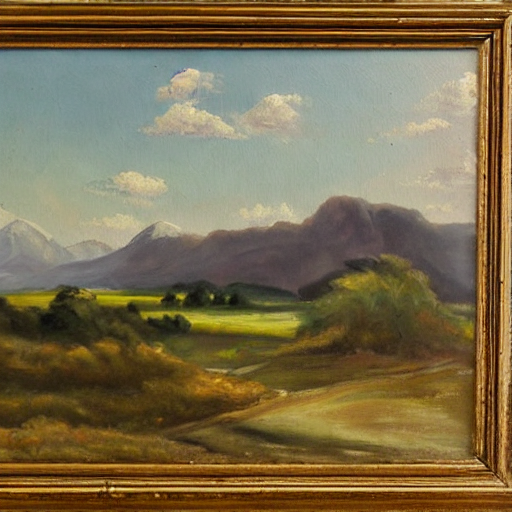

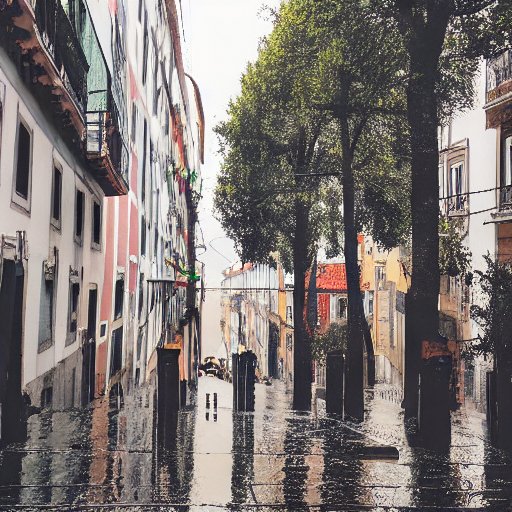

In [10]:
global_attentions=[]
for outs in prompts_outs:
    display(outs["image"])
    attn_map = colorize_attention(outs["tokens"],
        average_nested_attention(
            outs["cross_attn"]
        )
    )
    global_attentions.append(attn_map)
    display(HTML(attn_map))

In [ ]:
import imgkit

options = {
            'format': 'png',          
            'crop-w': '250',            
            'quiet': '',
            'encoding': "UTF-8"
        }


# save image
for i, out in enumerate(prompts_outs):
    out["image"].save(f"images/{i}.png")
    imgkit.from_string(global_attentions[i], f"images/{i}_global_attn.png", options)

### Global Attention throughout Diffusion

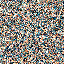

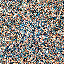

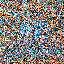

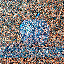

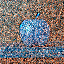

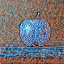

In [12]:
import imgkit

options = {
            'format': 'png',          
            'crop-w': '230',            
            'quiet': '',
            'encoding': "UTF-8"
        }

# display, for a single image, attention at different steps
image_idx = 0
steps = [0, 10, 20, 30, 40, 50]
for step in steps:
    attns = prompts_outs[image_idx]["cross_attn"][step]
    attn_map = colorize_attention(prompts_outs[image_idx]["tokens"],
        average_nested_attention(attns)
    )
    display(prompts_outs[image_idx]["latents"][step])
    display(HTML(attn_map))
    prompts_outs[image_idx]["latents"][step].save(f"images/{image_idx}_latent_s{step}.png")
    imgkit.from_string(attn_map, f"images/{image_idx}_attn_s{step}.png", options)

### Attention Across Blocks

In [ ]:
options = {
            'format': 'png',          
            'crop-w': '230',            
            'quiet': '',
            'encoding': "UTF-8"
        }

# display, for a single image and fixed timestep, attention from the up_blocks, middle_block, and down_blocks
image_idx = 1
step = -1

blocks = ["up_blocks", "mid_block", "down_blocks"]
for block in blocks:
    attns = [prompts_outs[image_idx]["cross_attn"][i][block] for i in range(51)]
    attn_map = colorize_attention(prompts_outs[image_idx]["tokens"],
        average_nested_attention(attns)
    )
    display(HTML(attn_map))
    imgkit.from_string(attn_map, f"images/{image_idx}_attn_{block}.png", options)

### Attention By Each Patch 

torch.Size([256, 9])


/tmp/ipykernel_2263706/1187290991.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20')


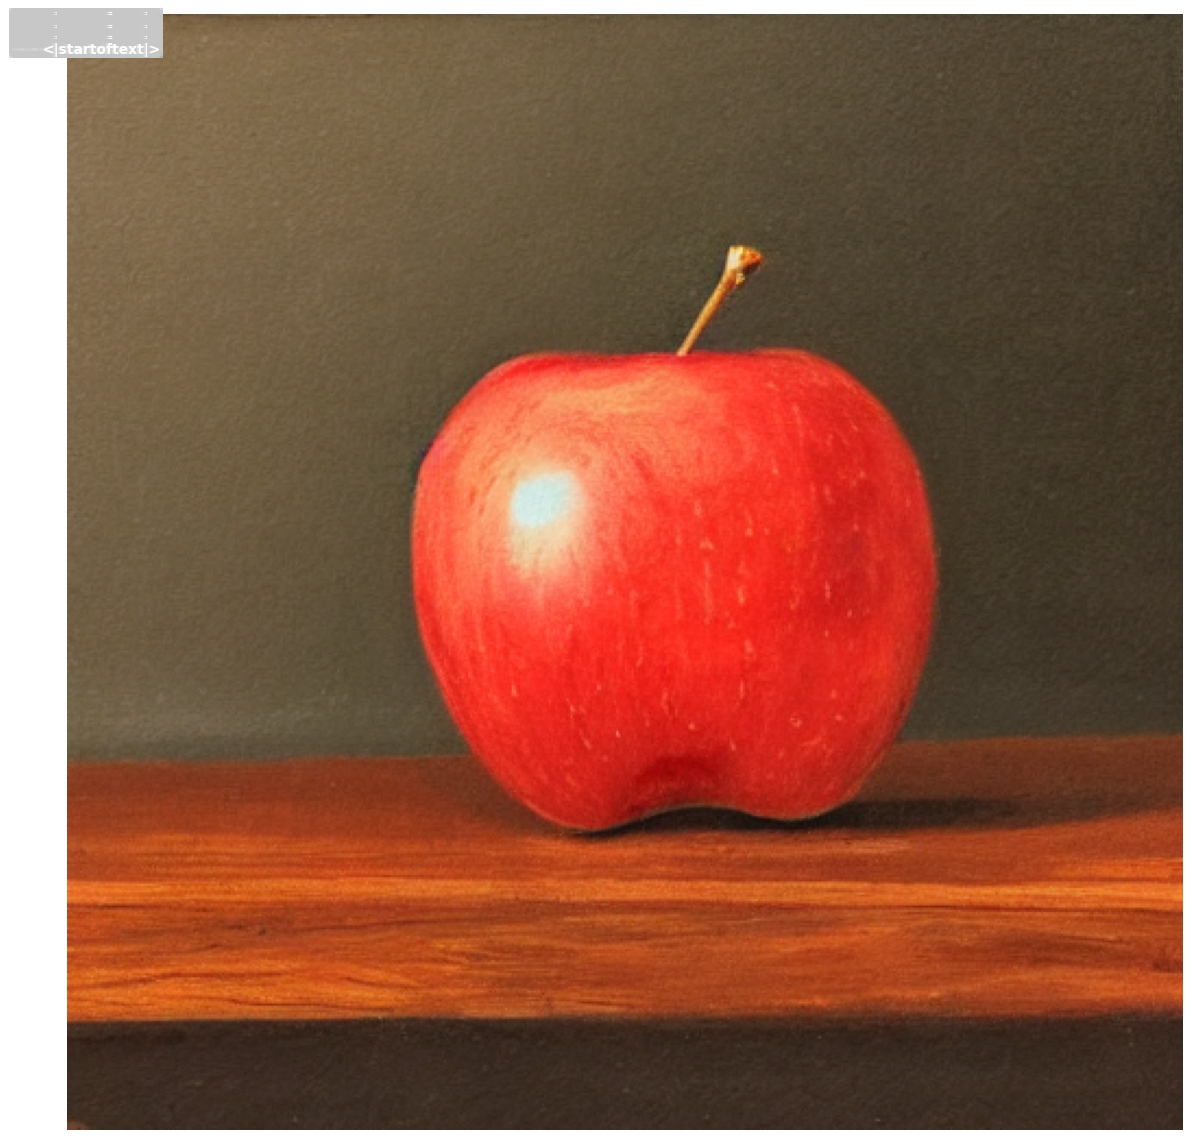

In [12]:
import torch
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba

def get_patch_token_attention(attention_structure, layer='up_blocks', step=-1):
    """
    Extract patch-level attention for a specific layer and step.
    """
    if isinstance(attention_structure[step][layer], list):
        attn = attention_structure[step][layer][0][0][0]
    else:
        attn = attention_structure[step][layer]
    
    # Average across heads  dimensions
    patch_attn = attn.mean(dim=0)
    print(patch_attn.shape)
    # reshape for square
    patch_attn = patch_attn.reshape(math.isqrt(patch_attn.shape[0]), math.isqrt(patch_attn.shape[0]), patch_attn.shape[1])
    
    # Get the token with maximum attention for each patch
    max_token_indices = patch_attn.argmax(dim=-1)
    return max_token_indices

def visualize_patch_token_attention(image, tokens, max_token_indices, num_patches=16):
    """
    Visualize which token each patch attends to most strongly.
    """
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(image)

    height, width = max_token_indices.shape
    patch_height, patch_width = height // num_patches, width // num_patches

    unique_tokens = list(set(tokens))
    color_map = plt.cm.get_cmap('tab20')
    token_colors = {token: color_map(i / len(unique_tokens)) for i, token in enumerate(unique_tokens)}

    for i in range(num_patches):
        for j in range(num_patches):
            y_start, x_start = i * patch_height, j * patch_width
            y_end, x_end = (i + 1) * patch_height, (j + 1) * patch_width
            
            patch_token_index = max_token_indices[y_start:y_end, x_start:x_end].mode().values.item()
            token = tokens[patch_token_index]
            color = token_colors[token]

            rect = patches.Rectangle((x_start, y_start), patch_width, patch_height, 
                                     linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)

            ax.text(x_start + patch_width/2, y_start + patch_height/2, token, 
                    color='white', weight='bold', ha='center', va='center',
                    bbox=dict(facecolor=to_rgba(color, 0.7), edgecolor='none', pad=1))

    plt.axis('off')
    plt.tight_layout()
    return fig

# Example usage
image_idx = 0  # Choose which image to visualize
outs = prompts_outs[image_idx]
image = outs['image']
tokens = outs['tokens']

max_token_indices = get_patch_token_attention(outs['cross_attn'])
fig = visualize_patch_token_attention(image, tokens, max_token_indices)
plt.show()

In [73]:
!pip install "matplotlib<3.9" 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 42.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.9.0
    Uninstalling matplotlib-3.9.0:
      Successfully uninstalled matplotlib-3.9.0
  You can safely remove it manually.


[7]
(512, 512)


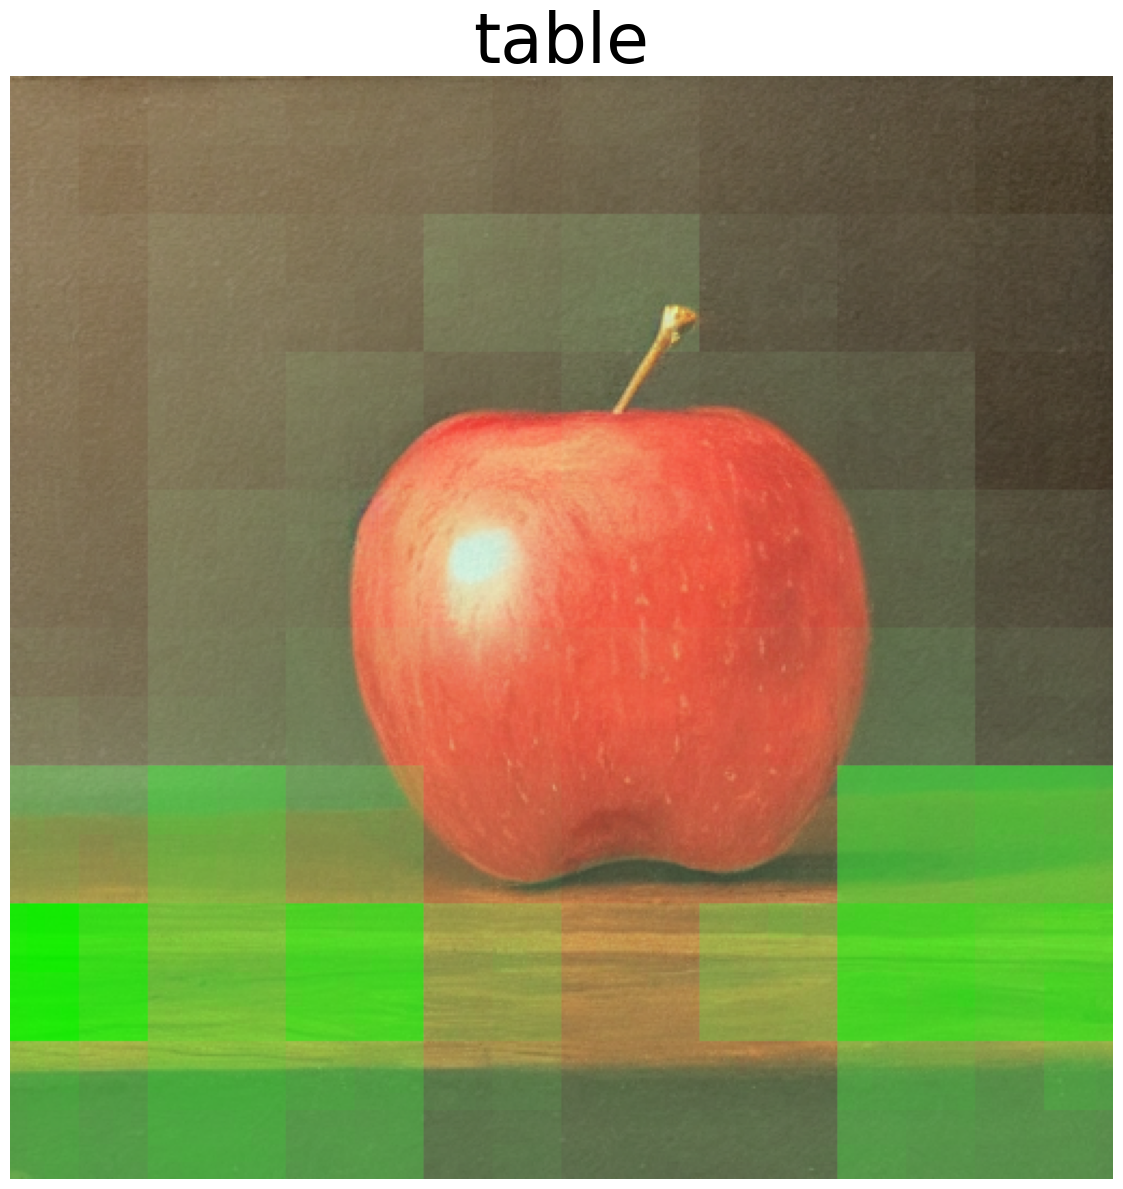

In [82]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import math
import numpy as np


def get_word_attention(
        attention_structure, 
        tokens, 
        word,
        image_size=(512, 512),
):
    """
    Extract attention weights for a specific word.
    """

    # Find the index of the word in the tokens
    word_indices = [i for i, token in enumerate(tokens) if word in token]

    print(word_indices)
    #import pdb; pdb.set_trace()
    
    if not word_indices:
        raise ValueError(f"Word '{word}' not found in tokens")

    def _tensor_map(attn):
        #import pdb; pdb.set_trace()
        # average over heads
        attn = attn.mean(dim=0)

        # pick word indices
        attn = attn[:, word_indices].sum(dim=-1)

        # reshape for square
        attn = attn.reshape(math.isqrt(attn.shape[0]), math.isqrt(attn.shape[0]))
        
        # Simple upscaling to max dimensions
        if attn.shape != image_size:
            h_factor = image_size[0] // attn.shape[0]
            w_factor = image_size[1] // attn.shape[1]
            attn = attn.repeat_interleave(h_factor, dim=0).repeat_interleave(w_factor, dim=1)
        
        #import pdb; pdb.set_trace()
        return attn

    word_attn = average_nested_attention(
        attention_structure, 
        tensor_map=_tensor_map
    )
    #import pdb; pdb.set_trace()

    return word_attn

def visualize_word_attention(image, word_attn, word):
    """
    Visualize attention for a specific word overlaid on the image.
    """
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Display the original image
    ax.imshow(image)
    
    # Normalize attention weights
    word_attn_np = word_attn.cpu().numpy()
    word_attn_np = (word_attn_np - word_attn_np.min()) / (word_attn_np.max() - word_attn_np.min())

    #image_np = np.array(image)
    #print(image_np.shape)
    #if word_attn_np.shape[:2] != image_np.shape[:2]:
    #    from scipy.ndimage import zoom
    #    zoom_factors = (image_np.shape[0] / word_attn_np.shape[0], 
    #                    image_np.shape[1] / word_attn_np.shape[1])
    #    word_attn_np = zoom(word_attn_np, zoom_factors, order=1)
    
    # Create a custom colormap with transparency
    colors = [(1, 1, 1, 0), (0, 1, 0, 1)]  # White (transparent) to Red (opaque)
    cmap = LinearSegmentedColormap.from_list("custom", colors, N=256)
    
    # Overlay attention heatmap
    print(word_attn_np.shape)
    attention_overlay = ax.imshow(word_attn_np, cmap=cmap, alpha=0.9)
    
    plt.title(f"{word}", fontsize=50)
    plt.axis('off')
    
    # Add colorbar
    #plt.colorbar(attention_overlay, ax=ax, label='Attention Strength')
    
    plt.tight_layout()
    return fig

# Example usage
image_idx = 0  # Choose which image to visualize
outs = prompts_outs[image_idx]
image = outs['image']
tokens = outs['tokens']

# Choose a word from the prompt
word_to_visualize = "table"  # Change this to any word in your prompt

word_attn = get_word_attention(outs['cross_attn'], tokens, word_to_visualize)
fig = visualize_word_attention(image, word_attn, word_to_visualize)
plt.show()

# save fig
fig.savefig(f"images/{image_idx}_word_attn_{word_to_visualize}.png")

In [31]:
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 69.6 MB/s eta 0:00:00:00:0100:01
